<a href="https://colab.research.google.com/github/RossanadC/Machine-Learning/blob/main/Lab3_TransferLearning_Catsvsdog_Pytorch_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset from Kaggle
For this section you have to get your kaggle credentials for more info you can check https://www.kaggle.com/docs/api?utm_me=

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

#upload kaggle.json
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#!kaggle competitions download -c dogs-vs-cats
!unzip /content/drive/MyDrive/ColabNotebooks/Lab03/dogs-vs-cats.zip
!unzip /content/drive/MyDrive/ColabNotebooks/Lab03/train.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       


# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

In [ ]:
!pip install torchsummary
from torchsummary import summary

# Prepare dataset

In [ ]:
batch_size=32
img_dimensions = 224

# Normalize to the ImageNet mean and standard deviation
# Could calculate it for the cats/dogs data set, but the ImageNet
# values give acceptable results here.
img_train_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((img_dimensions, img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

img_validation_transforms = transforms.Compose([
    transforms.Resize((img_dimensions,img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

# Dataset class

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [ ]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform = None):
        self.file_list=file_list
        self.transform=transform

    def __len__(self):
        self.filelength =len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path =self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0

        return img_transformed,label

# Split Train dataset into train and validation

In [ ]:
# Load train and test data
train_dir = 'train'
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))

from sklearn.model_selection import train_test_split
train_list,val_list = train_test_split(train_list , test_size =0.2)

In [ ]:
train_data = dataset(train_list,transform=img_train_transforms)
val_data = dataset(val_list,transform=img_validation_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size,shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = batch_size,shuffle = True)

In [ ]:
print(len(train_data),len(train_loader))
print(len(val_data), len(val_loader))

20000 625
5000 157


# Get Resnet18

In [ ]:
model_resnet18 = torch.hub.load('pytorch/vision', 'resnet18', weights=True)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 93.9MB/s]


Since we are doing transfer learning we want to freeze all params as here they are trained to the mean and standard deviation of ImageNet and we may lose some signal.

In [ ]:
for name, param in model_resnet18.named_parameters():
      param.requires_grad = False

Add Fully connected Layer on top of Resnet18

In [ ]:
num_classes = 2

model_resnet18.fc = nn.Sequential(nn.Linear(model_resnet18.fc.in_features,128),
                                  nn.ReLU(),
                                  nn.Linear(128, num_classes))

In [ ]:
from torchsummary import summary
summary(model_resnet18.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Train procedure

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device="gpu"):
    train_loss_epoch =  []
    valid_loss_epoch = []
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        train_loss_epoch.append(training_loss)
        valid_loss_epoch.append(valid_loss)
    return train_loss_epoch, valid_loss_epoch

# Check if we have GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Finetuning only the classifier head

In [ ]:
model = model_resnet18.to(device)
torch.compile(model)
optimizer = optim.Adam(params = model.parameters(),lr =0.01)
criterion = nn.CrossEntropyLoss()
train(model, optimizer, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=5, device=device)

Epoch: 0, Training Loss: 0.1997, Validation Loss: 0.0623, accuracy = 0.9754
Epoch: 1, Training Loss: 0.1579, Validation Loss: 0.0588, accuracy = 0.9774
Epoch: 2, Training Loss: 0.1439, Validation Loss: 0.0554, accuracy = 0.9776
Epoch: 3, Training Loss: 0.1373, Validation Loss: 0.0644, accuracy = 0.9770
Epoch: 4, Training Loss: 0.1348, Validation Loss: 0.0618, accuracy = 0.9750


([0.1997344640791416,
  0.15786237347573043,
  0.14387462426126002,
  0.13725069192275405,
  0.13480868617519737],
 [0.062282336090505125,
  0.05876985511165112,
  0.055407270820438864,
  0.06441613955795765,
  0.06179748632013798])


# Finetuning the backbone

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = True
optimizer = optim.Adam(params = model.parameters(),lr =0.0001)
criterion = nn.CrossEntropyLoss()
train(model, optimizer, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=5, device=device)

Epoch: 0, Training Loss: 0.1205, Validation Loss: 0.0612, accuracy = 0.9748
Epoch: 1, Training Loss: 0.0763, Validation Loss: 0.0538, accuracy = 0.9780
Epoch: 2, Training Loss: 0.0600, Validation Loss: 0.0520, accuracy = 0.9836
Epoch: 3, Training Loss: 0.0505, Validation Loss: 0.0507, accuracy = 0.9850
Epoch: 4, Training Loss: 0.0505, Validation Loss: 0.0438, accuracy = 0.9876


([0.12051813239702024,
  0.07628072612211108,
  0.060044250531541186,
  0.05048683852432296,
  0.05048336366582662],
 [0.06123202797789127,
  0.053761564469430596,
  0.051999312160210684,
  0.05065910614237655,
  0.04381087885410525])

In [ ]:

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/catsvsdogs.pth')

# Results

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        predictions = torch.argmax(model(images),dim=1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print('accuracy = {:f}'.format(correct / total))
print('correct: {:d}  total: {:d}'.format(correct, total))

accuracy = 0.987600
correct: 4938  total: 5000


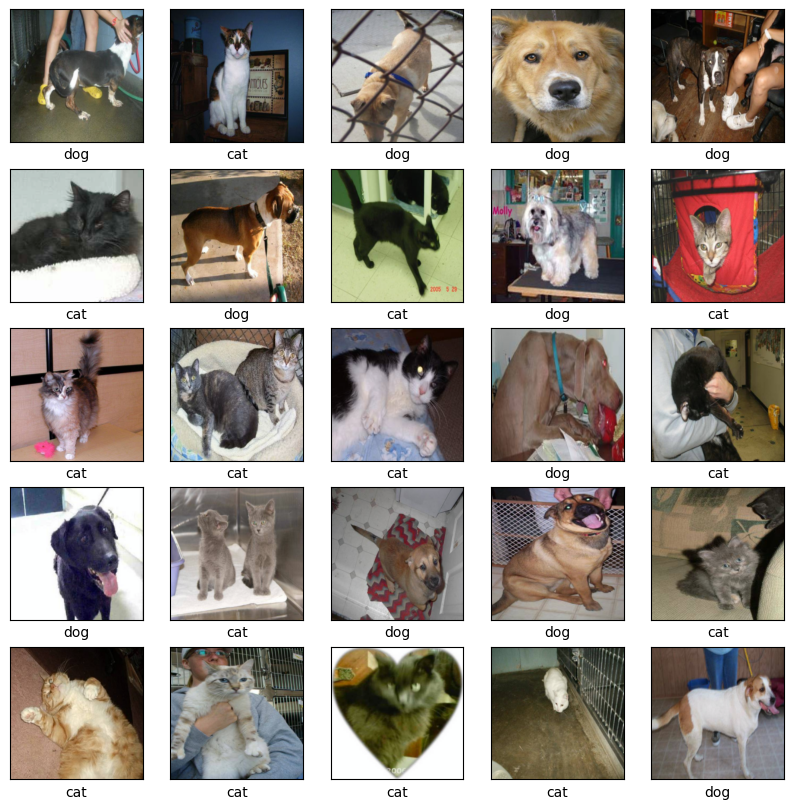

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class_names=['cat','dog']

# visualizzo alcuni esempi
iter_valid = iter(val_loader)
img_test, lbl_test = next(iter_valid)
preds_test = model(img_test.to(device))
img_test = img_test.numpy()


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img = img_test[i,:].transpose(1,2,0)
    img = img*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]

    plt.imshow((img * 255).astype(np.uint8))
    plt.xlabel(class_names[lbl_test[i]])
plt.show()

# Finetuning the entire network in one pass

Alternatively, it is possible to apply different learning rates to the classifier head (which is initialized randomly) and the backbone (which is fine-tuned from ImageNet), by setting up the otpimizer as follows:



```
params_to_update = [
     # New layers, trained from scratched
    {'params': model.fc.parameters(), 'lr': 1e-3},  
     # Pretrained backbone layers
    {'params': [param for name, param in model.named_parameters() if "fc" not in name and param.requires_grad], 'lr': 1e-4}
]

optimizer = optim.SGD(params_to_update, momentum=0.9)
```

